# Introduction

There are three main modeling approaches that can be taken for predictive maintenance we can call them: Outlier Frequency, Remaining Useful Life, and the standard Boolean Decision.

Outlier Frequency consists of making a model capable of predicting the future values of the continuous monitored variables during specified "good machine health" periods with the expectation that there is a good fit to the data. Then when the model trained to the healthy state is ran on data during periods where the machine deviates from a healthy condition the model is less accurate at predicting the future values. The model actually used for determining when a failure was imminent would actually be a simple threshold model using a cut off value for the amount of error between the actual reading and predicted, or perhaps the average error over the last 5 datapoints, etc.

the standard Boolean Decision models consists of models that most perople are already aware of such as Decision Trees, Random Forest, Logistic Regression, etc. These would be used to state whether or not a failure would occur at x time with x being a predetermined number of timesteps in the future.

Remaining Useful Life consists of creating a model that estimates the probability of the machine failing within x days, with x being a large range of days in the future. As time goes on the probabilities of failure for the future dates will start to increase, with the rate of the probability increase depending on the machines historical data.

Each of these methods have their pros and cons when it comes to model creation time, derived value, and its predictive power. At this time, a detailed list of the individual pros and cons will not be developed.

# Import Data & Packages

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import os
import seaborn as sns
sns.set_theme(context='notebook')
import datetime as dt

In [2]:
# Data
wd = os.getcwd()
base_path = wd.replace('notebooks', 'data')

# Machine Meta Data 
mach_meta = pd.read_csv(base_path + '\\PdM_machines.csv')

# Error Logs
err_log = pd.read_csv(base_path + '\\PdM_errors.csv')
err_log['datetime'] = pd.to_datetime(err_log['datetime'])
err_log.set_index('datetime', inplace=True)
err_log['errorID'] = err_log['errorID'].map(lambda x: x.lstrip('ero')) #strip the letters
err_log['errorID'] = err_log['errorID'].astype(int) #convert the error number to an integer

# Failure Logs
fail_log = pd.read_csv(base_path + '\\PdM_failures.csv')
fail_log['datetime'] = pd.to_datetime(fail_log['datetime'])
fail_log.set_index('datetime', inplace=True)
fail_log['Fail'] = 1

# Maintenance Logs
maint_log = pd.read_csv(base_path + '\\PdM_maint.csv')
maint_log['datetime'] = pd.to_datetime(maint_log['datetime'])
maint_log.set_index('datetime', inplace=True)
maint_log['Maint'] = 1

# Sensor Data
sens_data = pd.read_csv(base_path + '\\PdM_telemetry.csv')
sens_data['datetime'] = pd.to_datetime(sens_data['datetime'])
sens_data.set_index('datetime', inplace=True)

# Preprocessing

For the three methods listed above there are two ways that the data needs to be preprocessed. 

The remaining useful life requires no feature extraction, but does require breaking the data into individual time series based on the periods of time between failures. The individual time series would then have a new column that has the remaining useul life value, which would be linear decreasing from the start of the series to the failure. Since the machine is not new after being maintenanced or immediately following a failure, it is hard to decide if the remaining useful life should start at 100% at the beginning of a new series or not. Instead of having to decide now, let's pursue this method as our last option if the other methods do not work.

The other two methods require rolling the data into windows and using the raw data from those windows or calculating features of the windowed data.

## Roll Raw Sensor Data

In [3]:
def flat_rolling_wndw(wndw_size, mach):
    """
    for getting the raw values of rolled windows instead of features
    """
    col_names = [var + str(i) for i in range(wndw_size) for var in ['Volt-', 'Rot-', 'Press-', 'Vib-']]
    df = pd.DataFrame(columns=col_names, index=mach.index)
    
    rolled = mach.rolling(wndw_size, center=False, axis=0)

    i = 0
    #can this be completed faster?
    for r in rolled:
        r.sort_index(ascending=False, inplace=True)
        data = r.to_numpy().flatten().tolist()
        data = data + [0] * ((4*wndw_size) - len(data))
        df.iloc[i] = data 
        i += 1
        
    return df

In [4]:
# Break the data out for each machine
mach_data = [sens_data[sens_data['machineID'] == i] for i in range(1,101)]
for x in mach_data:
    x.sort_index(axis=0, inplace=True)
    x.drop(columns=['machineID'], inplace=True)

# Roll and flatten data for each machine
wndw_size = 5
raw_roll_mach_data = [flat_rolling_wndw(wndw_size, mach) for mach in mach_data] 

C:\Users\scosam\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-3-0e456b9bcbb8>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r.sort_index(ascending=False, inplace=True)


## Aggregated Rolled Sensor Data

In [5]:
feat_list = ['min', 'max', 'mean', 'sum', 'std', 'skew', 'kurt']
feat_roll_mach_data = [mach.rolling(wndw_size, center=False, axis=0).agg(feat_list) for mach in mach_data]

for mach in feat_roll_mach_data:
    mach.columns = ['_'.join(col).strip() for col in mach.columns.values] #combine multi level column names
    mach.dropna(axis=0, how='all', inplace=True)


## Add Logs to Rolled Data

In [6]:
# add the maintenance and error data
for i in range(1, 101):
    # Maintenance only included if it happened in the last hour
    ml = maint_log[maint_log['machineID'] == i]
    raw_roll_mach_data[i-1] = raw_roll_mach_data[i-1].merge(ml['Maint'], how='left', on='datetime')
    feat_roll_mach_data[i-1] = feat_roll_mach_data[i-1].merge(ml['Maint'], how='left', on='datetime')
    
    # Error only included if it occured in the last hour
    err = err_log[err_log['machineID'] == i]
    raw_roll_mach_data[i-1] = raw_roll_mach_data[i-1].merge(err['errorID'], how='left', on='datetime')
    feat_roll_mach_data[i-1] = feat_roll_mach_data[i-1].merge(err['errorID'], how='left', on='datetime')
    
    raw_roll_mach_data[i-1].fillna(0, inplace=True)
    feat_roll_mach_data[i-1].fillna(0, inplace=True)

## Create Target Variable

In [7]:
hour_offset = 5 # Hours you want to be able to predict in the future

for i in range(1, 101):
    fl = fail_log[fail_log['machineID'] == i]
    fl.index = fl.index - dt.timedelta(hours=hour_offset)
    
    raw_roll_mach_data[i-1] = raw_roll_mach_data[i-1].merge(fl['Fail'], how='left', on='datetime')
    feat_roll_mach_data[i-1] = feat_roll_mach_data[i-1].merge(fl['Fail'], how='left', on='datetime')

## Merge All Machines

In [8]:
raw_vals = pd.DataFrame(columns = raw_roll_mach_data[0].columns)
feat_vals = pd.DataFrame(columns = feat_roll_mach_data[0].columns)

for i in range(100):
    raw_vals = pd.concat([raw_vals, raw_roll_mach_data[i]], axis=0, ignore_index=True)
    feat_vals = pd.concat([feat_vals, feat_roll_mach_data[i]], axis=0, ignore_index=True)
    
raw_vals.fillna(0, inplace=True)
feat_vals.fillna(0, inplace=True)

## Error ID Encoding

There are three ways that we could encode the five error codes: one hot encoding, label encoding, or hash encoding.  

__Label encoding__ is typically used only for ordinal data, when there is some sort of time order or heirarchy associated with the variable (e.g. schooling or year). I believe this could be used for our case since it is an error ID number 
__One hot encoding__ makes a new boolean column for each category, where at any given time one column will have a 1, and all other columns are 0. This could work with us, but it will add four more columns and increase our dimensionality.  
__Hash encoding__ makes as many new columns as you want and then the combination of the values in the columns equates to a given category, like each column is a single byte of a string. In our case we would use 3 columns, because two columsn can make 4 unique values, while 3 columns can make 8 unique values.

For our situation there would not be much difference between the one hot encoding method and the hash encoding method. For now, we will stick with one hot encoding

## Oversample Failure Data?

## Train Test Splitting

In [9]:
from sklearn.model_selection import train_test_split

def split_data(df, test_size):
    X = df.drop(columns=['Fail'])
    y = df['Fail']
    
    return train_test_split(X, y, test_size=test_size)

## Normalizing

In [10]:
from sklearn.preprocessing import StandardScaler

def normalize(df, test_size, excluded):
    '''
    Scale the sensor data and split it into a training and testing split.
    df: The dataframe to perform the scaling and splitting on
    test_size: percent of data to hold off for model testing
    excluded: list of columns that do not require scaling
    '''
    X_train, X_test, y_train, y_test = split_data(df, test_size)
    X_train_ex = X_train.drop(columns=excluded)
    X_test_ex = X_test.drop(columns=excluded)
    col_names = X_train_ex.columns
    train_inds = X_train.index
    test_inds = X_test.index
    ss = StandardScaler()
    ss.fit(X_train_ex)
    X_train_ex = pd.DataFrame(ss.transform(X_train_ex), columns=col_names, index=train_inds)
    X_test_ex = pd.DataFrame(ss.transform(X_test_ex), columns=col_names, index=test_inds)
    X_train = pd.concat([X_train_ex, X_train[excluded]], axis=1)
    X_test = pd.concat([X_test_ex, X_test[excluded]], axis=1)
    
    return X_train, X_test, y_train, y_test



# Model Creation

Evaluation criteria selection:  
The overall goal for this model is to be able to always predict when a failure will occur without too much nuissance tripping. Having a bias towards getting 100% of the true positives, would mean that we want to have high recall for failure. However, since we also want to avoid nuissance tripping we also want to have a fairly high precision. Having high precision and recall essentially means we want to maximize our f1 score. having a high f1 score means that when the model flags 

Due to the nature of the problem and how little failures there are (700 in total), there is not a good baseline model to use. Obviously, if we always predict that a failure will occur then we will have 100% recall, but our precision would be 0, which would not be actually helpful since everyone would learn to ignore it due to it constantly crying wolf. However, just to get an idea of a worst case scenario we can make a couple of models that randomly guess if there will be a failure to get an idea of the distribution we can expect from it. After that, we can create a simple decision tree to give us a reasonable baseline score and help us identify some the aspects of the data that are useful for predicting failure.

## Standard Boolean Models

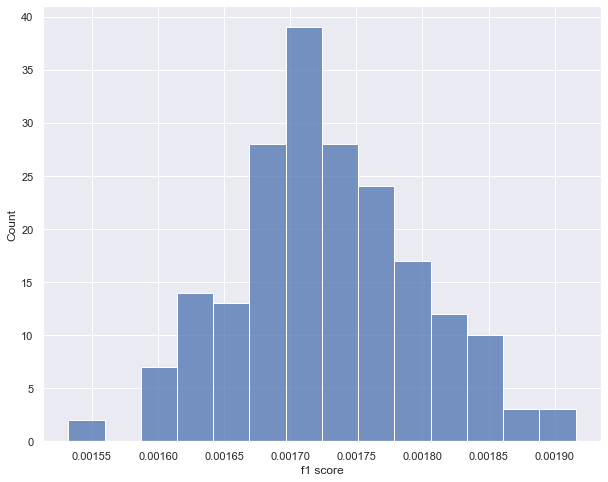

In [11]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score

X_train, X_test, y_train, y_test = normalize(raw_vals, 0.3, ['errorID', 'Maint'])

dummy_f1 = [] #get multiple f1 scores to determine the distribution
for i in range(200):
    dc = DummyClassifier(strategy='uniform')
    dc.fit(X_train, y_train)
    dummy_f1.append(f1_score(y_train, dc.predict(X_train)))

fig = plt.figure(figsize=(10,8))
sns.histplot(x=dummy_f1, bins=int(np.sqrt(200)))
plt.xlabel('f1 score')

plt.show()

A random guessing model results in a f1 score of approximately 0, with the average of the 200 samples hovering around 0.0018, so there is a lot of room for improvement.

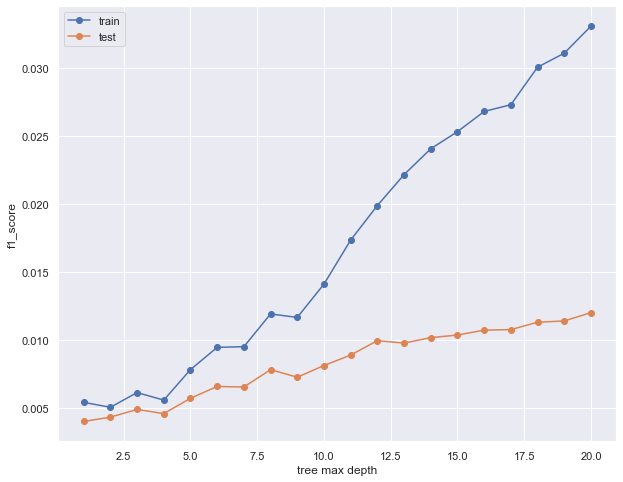

In [12]:
from sklearn.tree import DecisionTreeClassifier

tree_f1_train = []
tree_f1_test = []

for i in range(1, 21):
    tree_raw = DecisionTreeClassifier(max_depth=i, class_weight='balanced', random_state=100) # increases the weighting of the failure due to there being less of them
    tree_raw.fit(X_train, y_train)
    tree_f1_train.append(f1_score(y_train, tree_raw.predict(X_train)))
    tree_f1_test.append(f1_score(y_test, tree_raw.predict(X_test)))

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,21), tree_f1_train, marker='o', label='train')
plt.plot(range(1,21), tree_f1_test, marker='o', label='test')
plt.legend()
plt.ylabel('f1_score')
plt.xlabel('tree max depth')

plt.show()

So overall, there is a 10x improvement in f1 scores from the baseline random guessing model. However, the model is still far from good. One thing we could do is feed the model engineered features instead of the raw data for a 5 hour period.

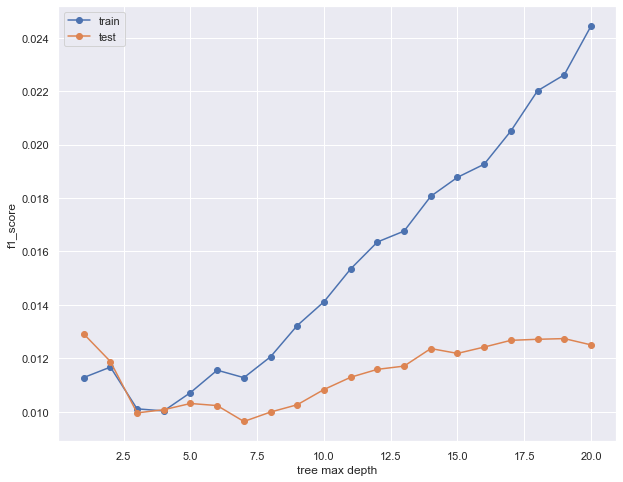

In [13]:
from sklearn.tree import DecisionTreeClassifier

tree_f1_train = []
tree_f1_test = []

X_train, X_test, y_train, y_test = normalize(feat_vals, 0.3, ['errorID', 'Maint']) # using our engineered features
for i in range(1, 21):
    tree_raw = DecisionTreeClassifier(max_depth=i, class_weight='balanced', random_state=100) # increases the weighting of the failure due to there being less of them
    tree_raw.fit(X_train, y_train)
    tree_f1_train.append(f1_score(y_train, tree_raw.predict(X_train)))
    tree_f1_test.append(f1_score(y_test, tree_raw.predict(X_test)))

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,21), tree_f1_train, marker='o', label='train')
plt.plot(range(1,21), tree_f1_test, marker='o', label='test')
plt.legend()
plt.ylabel('f1_score')
plt.xlabel('tree max depth')

plt.show()

There may be a slight improvement, but suprisingly not much over the raw data, and still very far away from what we would like. Now, we should start looking at some more complex models and using crossfold validation.

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

rf = RandomForestClassifier(max_depth=15, n_estimators=50 ,class_weight='balanced')
cv = cross_validate(rf, X_train, y_train, scoring='f1', cv=3, n_jobs=3, return_train_score=True)
cv

{'fit_time': array([ 94.37211514, 101.43453264,  94.13275385]),
 'score_time': array([0.94639325, 0.80682445, 0.96447778]),
 'test_score': array([0.01683876, 0.01576317, 0.0140477 ]),
 'train_score': array([0.05513745, 0.0654566 , 0.05673179])}

In [15]:
from sklearn.model_selection import RandomizedSearchCV

params ={'max_depth': np.linspace(4, 40, 40-3, dtype=int), 'n_estimators': np.linspace(20, 150, 150-19, dtype=int)}
rf = RandomForestClassifier(class_weight='balanced')
rscv = RandomizedSearchCV(rf, params, cv=3, verbose=1, n_jobs=6, scoring='f1', return_train_score=True, n_iter=30)
rscv.fit(X_train, y_train)

print('The best score obtain was {} using {} parameters'.format(rscv.best_score_, rscv.best_params_))

Fitting 3 folds for each of 30 candidates, totalling 90 fits
The best score obtain was 0.11003733342563927 using {'n_estimators': 141, 'max_depth': 39} parameters


Now with some optimization and more complex models we are nearing the E-1 range, but still far from something that could be useful. The next thing we can do is set up a model pipeline capable of varying the number of data points used to create our engineered features, and prediction time horizon. Once the pipeline is established we can test multiple model types to see if we can actually make an improvement.

In [16]:
def agg_feats(data, wndw_size, feat_list):
    '''
    data: a list of dataframes containing the time series sensor data
    wndw_size: number of timestamps to include in the feature creation
    feat_list: list of features to calculate on the rolled windows, if jsut the raw data desired use the string 'raw'
    '''
    if feat_list == 'raw':
        rolled_data = [flat_rolling_wndw(wndw_size, mach) for mach in data] 
    else:
        rolled_data = [mach.rolling(wndw_size, center=False, axis=0).agg(feat_list) for mach in data]

        for mach in rolled_data:
            mach.columns = ['_'.join(col).strip() for col in mach.columns.values] #combine multi level column names
            mach.dropna(axis=0, how='all', inplace=True)
            
    return rolled_data
            
def add_logs(data, maint, error, failure, offset):
    '''
    data: list of dataframes containing rolled window features
    maint: a log of when maintenace was performed
    '''
    for i in range(1, len(data)+1):
        # Maintenance only included if it happened in the last hour
        ml = maint[maint['machineID'] == i]
        data[i-1] = data[i-1].merge(ml['Maint'], how='left', on='datetime')

        # Error only included if it occured in the last hour
        err = error[error['machineID'] == i]
        data[i-1] = data[i-1].merge(err['errorID'], how='left', on='datetime')
        
        # Failures that occur in the future by the specified offset
        fl = failure[failure['machineID'] == i]
        fl.index = fl.index - dt.timedelta(hours=offset)
        data[i-1] = data[i-1].merge(fl['Fail'], how='left', on='datetime')

        data[i-1].fillna(0, inplace=True)
        
    return data
    
def merge_data(indv_data):
    data = pd.DataFrame(columns = indv_data[0].columns)

    for i in range(len(indv_data)):
        data = pd.concat([data, indv_data[i]], axis=0, ignore_index=True)
        
    return data

def pipeline(data, wndw_size, feat_list, maint_log, err_log, fail_log, fail_offset, test_size, excluded):
    
    #Break the data into windows
    feat_data = agg_feats(data, wndw_size, feat_list)
    
    # Add log data
    log_data = add_logs(feat_data, maint_log, err_log, fail_log, fail_offset)
    
    # Merge data
    merged_data = merge_data(log_data)
    
    # Normalize the data
    X_train, X_test, y_train, y_test = normalize(merged_data, test_size, excluded)
    
    return X_train, X_test, y_train, y_test

Now that our pipeline is established, we can quickly evaluate how the window size and the time prediction offset impacts our score while using multiple model algorithms.

In [17]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

feat_list = ['min', 'max', 'mean', 'sum', 'std', 'skew', 'kurt']
excluded = ['errorID', 'Maint']
test_size = 0.3

wndw_sizes = [5, 7, 10]
offsets = [2, 5]
models = {'rf': RandomForestClassifier(class_weight='balanced', n_estimators=125, max_depth=33), 
          'lr': LogisticRegression(class_weight='balanced'), 
          'gnb': GaussianNB(), 
          'svc': LinearSVC(class_weight='balanced')}

performance = []
for size in wndw_sizes:
    for offset in offsets:
        X_train, X_test, y_train, y_test = pipeline(mach_data, size, feat_list, maint_log, err_log, fail_log, offset, test_size, excluded)
        for model in models.keys():
            performance.append([model, size, offset, cross_validate(models[model], X_train, y_train, scoring='f1', cv=3, n_jobs=3, return_train_score=True)])

In [18]:
perf_df = pd.DataFrame(performance, columns = ['model type', 'wndw_size', 'prediction_offset', 'model_performance'])
test_scores = [np.mean(perf_df['model_performance'].loc[i]['test_score']) for i in range(len(perf_df))]
perf_df['test_scores'] = test_scores
perf_df.drop(columns=['model_performance'], inplace=True)
perf_df.sort_values('test_scores', ascending=False)

,model type,wndw_size,prediction_offset,test_scores
4,rf,5,5,0.039612
0,rf,5,2,0.032632
16,rf,10,2,0.029612
8,rf,7,2,0.025597
20,rf,10,5,0.025539
12,rf,7,5,0.023386
10,gnb,7,2,0.011766
17,lr,10,2,0.010713
21,lr,10,5,0.009519
18,gnb,10,2,0.009508


the general performance of the ranking, without too much optimization of hyperparameters is random forest, logistic regression, gaussian naive bayes, and lastly SVC. none of which were able to break past our optimized random forest model that obtained a f1 score of 0.06. Perhaps the next step is to use an even more advanced model such as a neural net. However, we will need to oversample the failure data since there is no weighting function available withing MLPClassifier.

## Oversampling

In [29]:
from imblearn.over_sampling import SMOTE

def new_samples(X, y):
    oversample = SMOTE()
    return oversample.fit_resample(X, y)

# update split data function
def split_data(df, test_size):
    X = df.drop(columns=['Fail'])
    y = df['Fail']
    
    X, y = new_samples(X, y)
    
    return train_test_split(X, y, test_size=test_size)

## Advanced Boolean Methods

In [26]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = pipeline(mach_data, 10, feat_list, maint_log, err_log, fail_log, 5, test_size, excluded)
nn_class = MLPClassifier(random_state=100, max_iter=1000)
params = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2]}
grid = GridSearchCV(nn_class, params, scoring='f1', cv=3, n_jobs=3, return_train_score=True)
grid.fit(X_train, y_train)
print('Train Results')
print(classification_report(y_train, grid.best_estimator_.predict(X_train)))
print('Test Results')
print(classification_report(y_test, grid.best_estimator_.predict(X_test)))
print(grid.best_params_)

Train Results
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    612612
         1.0       0.99      1.00      0.99    613095

    accuracy                           0.99   1225707
   macro avg       0.99      0.99      0.99   1225707
weighted avg       0.99      0.99      0.99   1225707

Test Results
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99    262893
         1.0       0.99      1.00      0.99    262410

    accuracy                           0.99    525303
   macro avg       0.99      0.99      0.99    525303
weighted avg       0.99      0.99      0.99    525303

{'alpha': 0.0001}


Now with an increased amount of failure samples we can get our recall up to nearly 100%. However, I am curious still to see how the neural net would perform on test data that did not have SMOTE failures, but just the original unbalanced test dataset. let's repeat this work with only the trainig data being balanced, and then let's try the random forest method again.

In [31]:
# rever the split function
def split_data(df, test_size):
    X = df.drop(columns=['Fail'])
    y = df['Fail']
    
    return train_test_split(X, y, test_size=test_size)

In [32]:
# using last 10 hours of data to predict if failure occurs 5 hours in the future
X_train, X_test, y_train, y_test = pipeline(mach_data, 10, feat_list, maint_log, err_log, fail_log, 5, test_size, excluded)
X_train, y_train = new_samples(X_train, y_train)
nn_class = MLPClassifier(random_state=100, max_iter=1000, alpha=0.0001)
nn_class.fit(X_train, y_train)
print('Train Results')
print(classification_report(y_train, nn_class.predict(X_train)))
print('Test Results')
print(classification_report(y_test, nn_class.predict(X_test)))

Train Results
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    612871
         1.0       0.99      1.00      1.00    612871

    accuracy                           1.00   1225742
   macro avg       1.00      1.00      1.00   1225742
weighted avg       1.00      1.00      1.00   1225742

Test Results
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    262634
         1.0       0.01      0.11      0.03       246

    accuracy                           0.99    262880
   macro avg       0.51      0.55      0.51    262880
weighted avg       1.00      0.99      1.00    262880



So using non-modified test features results in poor performance, but the score is sitll good for the training dataset. This indicates that we are overfitting, or there is something fundamentaly different between the SMOTE generated values and the original values. However, I think it more so has to do with the SMOTE values that were generated being more similar to each other especially since the values generated are influenced by the values used in the training. We could also try copying the values, which again could lead to overfitting of the training values.

In [33]:
# using last 10 hours of data to predict if failure occurs 5 hours in the future
X_train, X_test, y_train, y_test = pipeline(mach_data, 10, feat_list, maint_log, err_log, fail_log, 5, test_size, excluded)
X_train, y_train = new_samples(X_train, y_train)
X_test, y_test = new_samples(X_test, y_test)
nn_class = MLPClassifier(random_state=100, max_iter=1000, alpha=0.0001)
nn_class.fit(X_train, y_train)
print('Train Results')
print(classification_report(y_train, nn_class.predict(X_train)))
print('Test Results')
print(classification_report(y_test, nn_class.predict(X_test)))

Train Results
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    612860
         1.0       0.99      1.00      1.00    612860

    accuracy                           1.00   1225720
   macro avg       1.00      1.00      1.00   1225720
weighted avg       1.00      1.00      1.00   1225720

Test Results
              precision    recall  f1-score   support

         0.0       0.56      0.99      0.71    262645
         1.0       0.97      0.21      0.35    262645

    accuracy                           0.60    525290
   macro avg       0.76      0.60      0.53    525290
weighted avg       0.76      0.60      0.53    525290



using the SMOTE method, but keeping he training and testing data seperate to avoid contamination we still get a fairly low f1 score, but significantly better than our basic model that randomly guessed if a failure was going ot occur or not.

In [34]:
X_train, X_test, y_train, y_test = pipeline(mach_data, 10, feat_list, maint_log, err_log, fail_log, 5, test_size, excluded)
X_train, y_train = new_samples(X_train, y_train)
X_test, y_test = new_samples(X_test, y_test)
nn_class = MLPClassifier(random_state=100, max_iter=1000)
params = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2], 'hidden_layer_sizes': [(100,), (50,50), (100,100), (50,)]}
grid = GridSearchCV(nn_class, params, scoring='f1', cv=3, n_jobs=3, return_train_score=True)
grid.fit(X_train, y_train)
print('Train Results')
print(classification_report(y_train, grid.best_estimator_.predict(X_train)))
print('Test Results')
print(classification_report(y_test, grid.best_estimator_.predict(X_test)))
print(grid.best_params_)

Train Results
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    612846
         1.0       1.00      1.00      1.00    612846

    accuracy                           1.00   1225692
   macro avg       1.00      1.00      1.00   1225692
weighted avg       1.00      1.00      1.00   1225692

Test Results
              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69    262659
         1.0       0.98      0.11      0.20    262659

    accuracy                           0.55    525318
   macro avg       0.75      0.55      0.44    525318
weighted avg       0.75      0.55      0.44    525318

{'alpha': 0.0001, 'hidden_layer_sizes': (100, 100)}


It is still overfitting because it is using a portion of the training data as the test data to determine whic model is best. We need to instead seperate our data into three groups, train, test and validate. These individually could be oversampled and the test data could be used for hyperparameter determination, then use the validation data as our final test to verify we have a good model.